In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans
import random
from sklearn.neighbors import NearestNeighbors
import numpy as np
import collections
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
import os;
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from matplotlib import pyplot

In [192]:
# data.shape[1] # 行數    data.shape[0] 列數
os.chdir("/Users/emily/Desktop/Research/oversampling_python/data");
print(os.getcwd());

data = pd.read_excel("glass.xlsx")
#data.Class= data.Class.str.replace("\n", "").str.strip() # for pima.xlsx
data = data.iloc[:,1:]
data.shape[1]
l = data.shape[1]-1

output = np.array(data.iloc[:,l]);
output = LabelEncoder().fit_transform(output)
finaldata = np.array(data.iloc[:,:l])


/Users/emily/Desktop/Research/oversampling_python/data


class 0 count  70  percentage  32.710 %
class 1 count  76  percentage  35.514 %
class 2 count  17  percentage  7.944 %
class 3 count  13  percentage  6.075 %
class 4 count  9  percentage  4.206 %
class 5 count  29  percentage  13.551 %


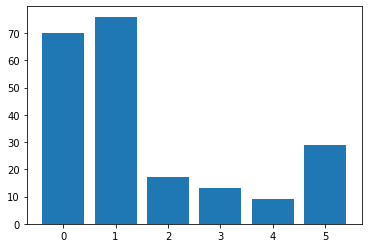

In [193]:
# 分佈
counter = Counter(output)
for k,v in counter.items():
	per = v / len(output) * 100
	print("class",k,"count ",v," percentage ",'%.3f' %per,"%")
	#print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [178]:
# 找出 knn
def knn(n_nu,sample):
     # n_nu 自己設定多少鄰近個點
     # input sample 沒有包含 class label
        nnarray = []
        neighbors=NearestNeighbors(n_neighbors=n_nu+1).fit(sample)
        for i in range(len(sample)):
            temp = neighbors.kneighbors(sample[i].reshape(1,-1),return_distance=False)[0]
            temp = np.delete(temp,0)
            # 有 array 存放 各個點的鄰近點 
            nnarray.append(temp)
        return nnarray # 回傳相近的點 分別是在第幾個 
karray = knn(3,finaldata)
len(karray)

214

In [179]:
# 找出大類
def find_maj(sample_class):
    counter = Counter(sample_class);
    maj = list(dict(counter.most_common(1)).keys())[0]
    #maj = "".join(maj)
    return maj

find_maj(output)

1

In [180]:
# 判斷該點為什麼類型的點 
# 此 index 是 0 開始 所以對照到 excel 的要
# inminority 是否是要求在小類中的 如果是則放 true
def check_point_type(n_nu,sample,sample_class,data,inminority):
    # 使用 find_maj(find_maj(sample_class)
    # 使用 knn 找到鄰近的幾個點 
    point_type = [] # 放個點是屬於什麼類型的 border safe noisy
    n = 0
    b = 0
    s = 0
    maj = find_maj(sample_class) # 大類
    #maj =2
    point = knn(n_nu,sample) # 回傳所有點鄰近 n_nu 個點
    #maj = "".join(maj) # maj 原本是 list 轉成 str
    for index,i in enumerate(point):
        maj_nu =0;
        if(data.iloc[index,data.shape[1]-1] == maj and inminority == True): # 如果該點本身是大類則不計算
            continue; # 如果使用此 則會跟論文的 data 一樣
        for j in point[index]: # 每個點鄰近個點的 loop 例如第一個點是 [1,2,3,4,5] 則 loop 裡面的數值
            if(data.iloc[j,data.shape[1]-1] == maj ): 
                maj_nu = maj_nu + 1 # 計算鄰近點為大類的有多少個
        if(maj_nu == n_nu ):
            point_type.append("noisy");
            n = n+1
        elif(n_nu/2 < maj_nu and maj_nu < n_nu ):
            point_type.append("border");
            b = b+1
        else:
            point_type.append("safe");
            s = s+1
    print("noisy",n,"\nborder",b,"\nsafe",s,"\nall",n+b+s)
    return point_type;
point_type = check_point_type(3,finaldata,output,data,True) # 論文使用 knn 為 3


noisy 9 
border 16 
safe 119 
all 144


In [211]:
len(output)

214

In [216]:
# 資料集變為小類的 border 跟 safe 以及 大類 去除 小類且為 noisy 的
"""
find the maximum value that existed for that attribute among
the minority samples of the 𝐵𝑆 set, and also, find the minimum value that existed for
the given attribute among the majority samples set
"""
# 先是小類去掉 noisy 再來是 大類 
def split_BS_Majdata(point_type,sample,sample_class):
    BS_sample = []
    Maj_sample = []
    return_sample = []
    maj = find_maj(sample_class) # 大類
    #maj = "".join(maj)
    for i in range(len(sample_class)):
        
        if(sample_class[i] == maj):
            Maj_sample.append(sample[i])
            
        elif(sample_class[i] != maj and point_type[i] != "noisy"):
            BS_sample.append(sample[i])
    return_sample = np.array([BS_sample ,Maj_sample ])
  
    return return_sample
point_type = check_point_type(3,finaldata,output,data,False)
split_BS_Majdata(point_type,finaldata,output)


noisy 44 
border 29 
safe 141 
all 214


array(['bs',
       list([array([ 1.51588824, 12.87795   ,  3.43036   ,  1.40066   , 73.282     ,
               0.68931   ,  8.04468   ,  0.        ,  0.1224    ]), array([ 1.5176423, 12.9777   ,  3.53812  ,  1.21127  , 73.002    ,
               0.65205  ,  8.52888  ,  0.       ,  0.       ]), array([ 1.52212996, 14.20795   ,  3.82099   ,  0.46976   , 71.77      ,
               0.11178   ,  9.5726    ,  0.        ,  0.        ]), array([1.51755118e+00, 1.33900000e+01, 3.65935000e+00, 1.18880000e+00,
              7.27892000e+01, 5.71320000e-01, 8.27064000e+00, 0.00000000e+00,
              5.61000000e-02]), array([ 1.51755118, 13.1506    ,  3.60996   ,  1.05077   , 73.2372    ,
               0.57132   ,  8.23836   ,  0.        ,  0.        ]), array([ 1.51793844, 13.21045   ,  3.47975   ,  1.41029   , 72.638     ,
               0.58995   ,  8.43204   ,  0.        ,  0.        ]), array([ 1.51898632, 13.58285   ,  3.34954   ,  1.23053   , 72.078     ,
               0.58995   ,  8.

In [214]:
def index_split_BS_Majdata(point_type,sample,sample_class): # maj 以及 BS set 在原本 data 的 index
    BS_sample = []
    Maj_sample = []
    return_sample = []
    maj = find_maj(sample_class) # 大類
    #maj = "".join(maj)
    for i in range(len(sample_class)):
        #print(sample_class[i])
        
        if(sample_class[i] == maj):
            Maj_sample.append(i)
            
        elif(sample_class[i] != maj and point_type[i] != "noisy"):
            BS_sample.append(i)
    return_sample = np.array([ BS_sample ,Maj_sample ])
    
    return return_sample
point_type = check_point_type(3,finaldata,output,data,False)
index_split_BS_Majdata(point_type,finaldata,output) 

noisy 44 
border 29 
safe 141 
all 214


array(['vs',
       list([0, 1, 2, 4, 6, 8, 9, 12, 14, 16, 18, 23, 25, 26, 28, 29, 32, 34, 35, 39, 44, 45, 46, 47, 48, 50, 58, 61, 62, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 195, 196, 197, 208, 209, 210, 211, 212, 213]),
       'ma',
       list([63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 198, 199, 200, 201, 202, 203, 204, 205])],
      dtype=object)

In [204]:
def classprocess(output):
    c = Counter(output)
    datagap = []
    maj = find_maj(output)
    maj_num = dict(c)[find_maj(output)]
    for className, number in counter.items(): 
        #print(className," ",number)
        temp = np.array([className,(maj_num - number)])
        datagap.append(temp)
    return datagap

classprocess(output)


[array([0, 6]),
 array([1, 0]),
 array([ 2, 59]),
 array([ 3, 63]),
 array([ 4, 67]),
 array([ 5, 47])]

In [208]:
finaldata[0]

array([ 1.51588824, 12.87795   ,  3.43036   ,  1.40066   , 73.282     ,
        0.68931   ,  8.04468   ,  0.        ,  0.1224    ])

In [209]:
"""
The obtained ranges for
all features (attributes) are used to control the location of the new synthetic samples in
data space.

The set of these ranges is denoted by 𝑅𝑎𝑛𝑔𝑒 =
(𝑟𝑎𝑛𝑔𝑒1 𝑟𝑎𝑛𝑔𝑒2 𝑟𝑎𝑛𝑔𝑒3 … 𝑟𝑎𝑛𝑔𝑒𝑛𝑎𝑡𝑡𝑟) array where 𝑛𝑎𝑡𝑡𝑟 is the number of
attributes in the dataset

如何產生 Range array
1. we find the maximum value that existed for that attribute among
the minority samples of the 𝐵𝑆 set  𝑃 _𝑚𝑎𝑥 = (𝑝𝑚𝑎𝑥1 𝑝𝑚𝑎𝑥2
…𝑝𝑚𝑎𝑥𝑛𝑎𝑡𝑡𝑟) array

2. find the minimum value that existed for
the given attribute among the majority samples set  𝑁 _𝑚𝑖𝑛 = (𝑛𝑚𝑖𝑛1 𝑛𝑚𝑖𝑛2 …𝑛𝑚𝑖𝑛𝑛𝑎𝑡𝑡𝑟)array

3. Then, the desired 𝑅𝑎𝑛𝑔𝑒 vector is obtained as the average of 𝑁_𝑚𝑖𝑛 and
𝑃 _𝑚𝑎𝑥 arrays

"""
# dataframe[0] 行數  dataframe[1] 列數
# 該屬性中 在 bs set 的最大值 以及 大類中的最小值
# range 為兩個相加除以 2
# index_split_BS_Majdata 回傳 [0] BS set [1] 回傳 Maj set
def range_value(n_nu,sample,sample_class,data):
    point_type = check_point_type(n_nu,sample,sample_class,data,False)
    index = index_split_BS_Majdata(point_type,sample,sample_class)
    BS_max = []
    Maj_min = []
    all_value = []
    for i in range(len(sample[0])): # loop 屬性
        for j in range(2): # loop data
            if(j==0): # BS set 的 index
                BS_index = index[j]
                max_value = np.max(sample[BS_index][i]);
                BS_max.append(max_value)
            else:
                Maj_index = index[j]
                min_value = np.min(sample[Maj_index][i]);
                Maj_min.append(min_value)
    # temp = np.array([BS_max,Maj_min]) 
    range_value = [(BS_max[i] - Maj_min[i])/2 for i in range(len(BS_max))]
    all_value = np.array([BS_max,Maj_min,range_value])
    return all_value
range_value(3,finaldata,output,data)

noisy 44 
border 29 
safe 141 
all 214


IndexError: index 2 is out of bounds for axis 0 with size 2

In [185]:
# b𝑛𝑢𝑚: Number of samples in 𝐵𝑜𝑟𝑑𝑒𝑟 屬於 border 的資料數
# compute its(border sample) k nearest neighbors in BS, and save them in BSnn 存放 
# compute its(border sample) k nearest neighbors in Maj set, and save them in Majnn
def getBSnn_Majnn(n_nu,sample,sample_class,data):     
    point_type = check_point_type(n_nu,sample,sample_class,data,False) # 得知所有 sample 中屬於 border 的  
    index = index_split_BS_Majdata(point_type,sample,sample_class) 
    k = knn(n_nu,sample)
    BSnn = []
    Majnn = []
    # 用 border sample 的 index 
    for i,element in enumerate(point_type):
        if(element == "border"):
            for j in range(2):
                for w in index[j]:
                    if(j == 0 and i == w ):
                        BSnn.append(k[w])
                    elif(j==1 and i == w):
                        Majnn.append(k[w])
        
    temp = np.array([BSnn,Majnn]);
    print(len(temp[0]+temp[1]))
    return temp
    
len(getBSnn_Majnn(3,finaldata,output,data)[0][0])


noisy 44 
border 29 
safe 141 
all 214
29


3

In [186]:
# 生成資料

def Populate(r,BSnn,Majnn,Range,P_max,sample,classbelong):
    # r 代表要產生的資料的數量 論文定義該數量為增加小類至跟大類相同的數量 達成 50% (大類減小類的數量)
    
    Bl = len(BSnn)-1
    nn_nu = len(BSnn[0])-1
    Ml = len(Majnn)-1
    Synthetic = []
    while(r > 0):
        s1row = random.randint(0,Bl)
        s1col = random.randint(0,nn_nu)
        s1 = BSnn[s1row][s1col]
        s2row = random.randint(0,Ml)
        s2col = random.randint(0,nn_nu)
        s2 = Majnn[s2row][s2col]
        min_attr = []
        for i in range(len(sample[0])):
        
            if(sample[s1][i] < sample[s2][i]):
                min_attr.append(sample[s1][i])
            else:
                min_attr.append(sample[s2][i])
        diff = [(P_max[i] - min_attr[i]) for i in range(len(P_max))]
        #print("diff",diff)
        gap = random.uniform(0,0.5)
        var = [(diff[i] * gap ) for i in range(len(diff))]
        temp = []
        for i in range(len(sample[0])):
            if(min_attr[i]+var[i] <= Range[i]):
                temp.append(min_attr[i]+var[i])
            else:
                temp.append(P_max[i]-var[i])
        temp.append(classbelong) # 應該要變成該類別名字
        Synthetic.append(temp)   
        r = r-1
    return Synthetic
    
needToGenerate = 232
BSnn = getBSnn_Majnn(3,finaldata,output,data)[0]
print("Majnn",len(Majnn[1]))
Majnn = getBSnn_Majnn(3,finaldata,output,data)[1]
Range = range_value(3,finaldata,output,data)
P_max = range_value(3,finaldata,output,data)[0]
Range = range_value(3,finaldata,output,data)[2]
#Populate(needToGenerate,BSnn,Majnn,Range,P_max,finaldata,)

noisy 44 
border 29 
safe 141 
all 214
29
Majnn 3
noisy 44 
border 29 
safe 141 
all 214
29
noisy 44 
border 29 
safe 141 
all 214
noisy 44 
border 29 
safe 141 
all 214
noisy 44 
border 29 
safe 141 
all 214


In [187]:
classCount = classprocess(output)
classCount


[array([0, 6]),
 array([1, 0]),
 array([ 2, 59]),
 array([ 3, 63]),
 array([ 4, 67]),
 array([ 5, 47])]

In [200]:
# 每個類別都要 進行 populate 針對多類別
alldata = data.T
classCount = classprocess(output)
index = 1
for i in range(len(classCount)):
    over = Populate(classCount[i][1],BSnn,Majnn,Range,P_max,finaldata,classCount[i][0])
    length = alldata.shape[1]
    for j in range(len(over)):
        alldata[length+j] = over[j]
      
alldata.to_csv("tes.csv")

In [169]:
y = alldata.iloc[len(alldata)-1,:]
y
w = Counter(y)
w
for k,v in w.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=1, n=76 (16.667%)
Class=2, n=76 (16.667%)
Class=3, n=76 (16.667%)
Class=5, n=76 (16.667%)
Class=6, n=76 (16.667%)
Class=7, n=76 (16.667%)


Class=0, n=76 (16.667%)
Class=1, n=76 (16.667%)
Class=2, n=76 (16.667%)
Class=3, n=76 (16.667%)
Class=4, n=76 (16.667%)
Class=5, n=76 (16.667%)


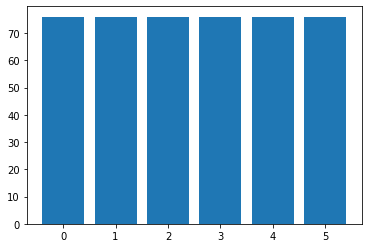

Mean Accuracy: 0.910 (0.023)


In [190]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from numpy import mean
from numpy import std
output = LabelEncoder().fit_transform(output)
# transform the dataset
oversample = SMOTE()
finaldata,output = oversample.fit_resample(finaldata,output)
# summarize distribution
counter = Counter(output)
# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()
model = RandomForestClassifier(n_estimators=1000)
# evaluate the model
scores = evaluate_model(finaldata, output, model)
# summarize performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

In [189]:
# RCSMOTE
X = alldata.T.iloc[:,:len(alldata)-1]
y = alldata.T.iloc[:,len(alldata)-1]

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from numpy import mean
from numpy import std
#y = LabelEncoder().fit_transform(y)
# transform the dataset

# summarize distribution
counter = Counter(y)
# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

model = RandomForestClassifier(n_estimators=1000)
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


Mean Accuracy: 0.507 (0.037)


In [ ]:
# Borderline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
steps = [('border_line', BorderlineSMOTE(random_state=42,kind="borderline-1")), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, finaldata, output, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

In [198]:
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
 
# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	data = read_csv(full_path, header=None)
	# retrieve numpy array
	data = data.values
	# split into input and output elements
	X, y = data[:, :-1], data[:, -1]
	# label encode the target variable to have the classes 0 and 1
	y = LabelEncoder().fit_transform(y)
	return X, y
 
# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define the location of the dataset
full_path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/glass.csv'
# load the dataset
X, y = load_dataset(full_path)
# define the reference model
model = RandomForestClassifier(n_estimators=1000)
# evaluate the model
scores = evaluate_model(X, y, model)
counter = Counter(y)
for i,v in counter.items():
    print("class",i,"cou",v)
# summarize performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

class 0 cou 70
class 1 cou 76
class 2 cou 17
class 3 cou 13
class 4 cou 9
class 5 cou 29
Mean Accuracy: 0.796 (0.066)
